# Prostate Zone Atlas Construction
Use a PCA to perform Prostate Zone Atlas Construction of central gland (CG).

In [1]:
import itertools
import re
import sys
# import vtk

from tqdm import tqdm


import matplotlib.pyplot as plt
import matplotlib.colors as colors

from skimage import measure
from sklearn.decomposition import PCA
import seaborn as sns


import IPython
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import pandas as pd
import pytorch_lightning
import torch
from torch.utils.data import DataLoader

import monai
from monai.transforms import \
    Compose, LoadImaged, AddChanneld, Orientationd, \
    CropForegroundd, \
    Resized, \
    ToNumpyd, \
    AsDiscreted, \
    NormalizeIntensityd, ScaleIntensityRangePercentilesd, \
    SpatialPadd, Spacingd, \
    RandSpatialCropd, \
    RandCropByPosNegLabeld, ToTensord, ToTensor, \
    DataStatsd, AsDiscrete, KeepLargestConnectedComponent 
from monai.data import list_data_collate,decollate_batch
from monai.networks.layers import Norm

from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


monai.config.print_config()

MONAI version: 0.6.0
Numpy version: 1.19.2
Pytorch version: 1.10.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0ad9e73639e30f4f1af5a1f4a45da9cb09930179

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.1.1
scikit-image version: 0.17.2
Pillow version: 8.1.0
Tensorboard version: 2.2.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.8.2
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.55.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.1
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Set the project path

In [2]:
EXP_NAME = 'cg_atlas'
ROOT_PATH = '../resources'
EXP_PATH = os.path.join(ROOT_PATH,EXP_NAME.lower())

# Create the study directory structure
if not os.path.exists(EXP_PATH):
    print('Creating experiment directory: {}'.format(EXP_PATH))
    os.mkdir(EXP_PATH)

print('Using experiment directory: {}'.format(EXP_PATH))

Using experiment directory: ../resources/cg_atlas


## Load ProstateX and Prostate 3T Data

In [3]:
PROSTATEX_PATH = r'../resources/data/ProstateX_data_index.csv'

df_prostatex = pd.read_csv(PROSTATEX_PATH, index_col=False)
df_prostatex = df_prostatex.dropna(subset=['SEGM_PIRADS'])
df_prostatex.drop_duplicates(inplace=True)
df_prostatex = df_prostatex.rename(columns={
    'SEGM_PIRADS': 'SEGM',
    'IMAGE': 'IMAGE'
})

print('Dataset contains %d entries' % len(df_prostatex))
df_prostatex.head(5)

Dataset contains 98 entries


,SUBJECT_ID,VISIT_ID,IMAGE,SEGM,DATASET_ID
5,4,0,/data16/public/prostate/data/public/from_tenso...,/data16/public/prostate/data/public/from_tenso...,ProstateX
8,7,0,/data16/public/prostate/data/public/from_tenso...,/data16/public/prostate/data/public/from_tenso...,ProstateX
10,9,0,/data16/public/prostate/data/public/from_tenso...,/data16/public/prostate/data/public/from_tenso...,ProstateX
15,12,0,/data16/public/prostate/data/public/from_tenso...,/data16/public/prostate/data/public/from_tenso...,ProstateX
18,15,0,/data16/public/prostate/data/public/from_tenso...,/data16/public/prostate/data/public/from_tenso...,ProstateX


In [4]:
PROSTATE3T_PATH = r'../resources/data/Prostate3T_data_index.csv'

df_prostate3t = pd.read_csv(PROSTATE3T_PATH, index_col=False)
df_prostate3t.drop_duplicates(inplace=True)

print('Dataset contains %d entries' % len(df_prostate3t))
df_prostate3t.head(5)

Dataset contains 30 entries


,SUBJECT_ID,IMAGE,SEGM,SEGM_PROSTATE,DATASET_ID
0,1,/data16/public/prostate/data/public/TCIA/Prost...,/data16/public/prostate/data/public/TCIA/Prost...,/data16/public/prostate/data/public/TCIA/Prost...,Prostate3T
1,2,/data16/public/prostate/data/public/TCIA/Prost...,/data16/public/prostate/data/public/TCIA/Prost...,/data16/public/prostate/data/public/TCIA/Prost...,Prostate3T
2,3,/data16/public/prostate/data/public/TCIA/Prost...,/data16/public/prostate/data/public/TCIA/Prost...,/data16/public/prostate/data/public/TCIA/Prost...,Prostate3T
3,4,/data16/public/prostate/data/public/TCIA/Prost...,/data16/public/prostate/data/public/TCIA/Prost...,/data16/public/prostate/data/public/TCIA/Prost...,Prostate3T
4,5,/data16/public/prostate/data/public/TCIA/Prost...,/data16/public/prostate/data/public/TCIA/Prost...,/data16/public/prostate/data/public/TCIA/Prost...,Prostate3T


In [5]:
# Convert DF to dictionary
prostatex_data_dict = df_prostatex.to_dict('records')
prostate3t_data_dict = df_prostate3t.to_dict('records')

print('Number of ProstateX files: ', len(prostatex_data_dict))
print('Number of Prostate3T files: ', len(prostate3t_data_dict))

Number of ProstateX files:  98
Number of Prostate3T files:  30


## Load data using MONAI

In [6]:
SPACING = (1,1,3)
SIZE = (96,96,32)
MARGIN = 8

prostatex_transforms = Compose([
    LoadImaged(keys=['IMAGE', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['IMAGE', 'SEGM']),
    Orientationd(keys=['IMAGE', 'SEGM'], axcodes='RAS'),
    # Standardize spacing so that the margin is consistent around all glands
    Spacingd(
        keys=['IMAGE', 'SEGM'], 
        pixdim=SPACING, 
        mode=('bilinear', 'nearest'), 
        padding_mode=('reflection','reflection')
    ),
    CropForegroundd(keys=['IMAGE','SEGM'], 
                    source_key='SEGM', select_fn=lambda x: x>0, margin=MARGIN),
    Resized(keys=['IMAGE', 'SEGM'], spatial_size=SIZE, mode=('trilinear', 'nearest')),
    ScaleIntensityRangePercentilesd(keys=['IMAGE'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
    ToTensord(keys=['SEGM']),
])


prostate3t_transforms = Compose([
    LoadImaged(keys=['IMAGE', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['IMAGE', 'SEGM']),
    Orientationd(keys=['IMAGE', 'SEGM'], axcodes='RAS'),
    # Standardize spacing so that the margin is consistent around all glands
    Spacingd(
        keys=['IMAGE', 'SEGM'], 
        pixdim=SPACING, 
        mode=('bilinear', 'nearest'), 
        padding_mode=('reflection','reflection')
    ),
    CropForegroundd(keys=['IMAGE','SEGM'], 
                    source_key='SEGM', select_fn=lambda x: x>0, margin=MARGIN),
    Resized(keys=['IMAGE', 'SEGM'], spatial_size=SIZE, mode=('trilinear', 'nearest')),
    ScaleIntensityRangePercentilesd(keys=['IMAGE'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
    ToTensord(keys=['SEGM']),
])

## Create a Data Cache

In [11]:
# Load all the data
prostatex_ds = monai.data.CacheDataset(data=prostatex_data_dict, 
                                       transform=prostatex_transforms, cache_rate=1.0, num_workers=10)
prostatex_loader = DataLoader(prostatex_ds, batch_size=1, num_workers=4, collate_fn=list_data_collate)

Loading dataset: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]


In [8]:
prostate3t_ds = monai.data.CacheDataset(data=prostate3t_data_dict, 
                                        transform=prostate3t_transforms, cache_rate=1.0, num_workers=10)
prostate3t_loader = DataLoader(prostate3t_ds, batch_size=1, num_workers=4, collate_fn=list_data_collate)

Loading dataset: 100%|██████████| 30/30 [00:05<00:00,  5.17it/s]


In [9]:
to_one_hot = AsDiscreted(keys=['SEGM'], to_onehot=True, n_classes=5)

pX_image_list = list()
pX_segm_list = list()
for d in tqdm(prostatex_loader):
    pX_image_list.append(d['IMAGE'])
    d = monai.data.decollate_batch(d)[0]
    d_one_hot = to_one_hot(d)
    pX_segm_list.append(d_one_hot['SEGM'])


100%|██████████| 98/98 [00:06<00:00, 14.51it/s]


In [12]:
to_one_hot = AsDiscreted(keys=['SEGM'], to_onehot=True, n_classes=3)

p3t_image_list = list()
p3t_segm_list = list()
for d in tqdm(prostate3t_loader):
    p3t_image_list.append(d['IMAGE'])
    d = monai.data.decollate_batch(d)[0]
    d_one_hot = to_one_hot(d)
    p3t_segm_list.append(d_one_hot['SEGM'])


100%|██████████| 30/30 [00:02<00:00, 13.86it/s]


## Get all sector samples
We all augment these with a left-right flip to average the symmetric results.

In [13]:
prostatex_image = np.concatenate(pX_image_list, axis=0)
print(prostatex_image.shape)

prostatex_segm = np.stack(pX_segm_list, axis=0)
print(prostatex_segm.shape)

(98, 1, 96, 96, 32)
(98, 5, 96, 96, 32)


In [14]:
prostate3t_image = np.concatenate(p3t_image_list, axis=0)
print(prostate3t_image.shape)

prostate3t_segm = np.stack(p3t_segm_list, axis=0)
print(prostate3t_segm.shape)

(30, 1, 96, 96, 32)
(30, 3, 96, 96, 32)


(1, 1, 96, 96, 32)
(1, 5, 96, 96, 32)


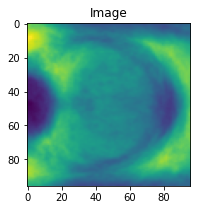

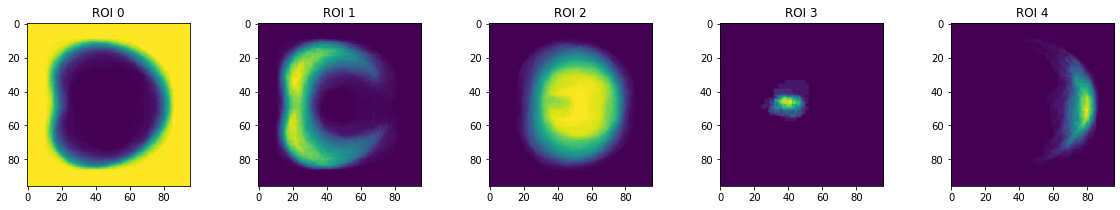

In [15]:
# Create the average sector values over all subjects
image_avg = np.mean(prostatex_image, axis=0, keepdims=True)
print(image_avg.shape)

pirads_avg = np.mean(prostatex_segm, axis=0, keepdims=True)
print(pirads_avg.shape)

slice_num = image_avg.shape[-1]//2

plt.figure('Anatomical Average', (20, 3))
plt.title('Image')
plt.imshow(image_avg[0,0,:,:,slice_num])
plt.show()


plt.figure('PIRADS Zone Average', (20, 3))
for i in range(pirads_avg.shape[1]):    
    plt.subplot(1, 5, i+1)
    plt.title('ROI {}'.format(i))
    plt.imshow(pirads_avg[0,i,:,:,slice_num])
plt.show()


## PCA utility functions

In [16]:
def pca_image(X, n_components=None):
    """Compute the PCA of image data in variable X.
    
    PCA is peformed on the flattened data.
    
    Inputs:
        X: numpy array of shape [B,C,H,W,[D]]
    
    """
    X_f = batch_flatten(X)
    
    pca = PCA(n_components=n_components)
    pca.fit(X_f)
    
    return pca


def batch_flatten(X):
    X_f = np.reshape(X, (X.shape[0],-1))
    return X_f


def batch_unflatten(X_f, size):
    out_shape = [X_f.shape[0]]+list(size)
    X = np.reshape(X_f, out_shape)
    return X


def pca_image_transform(X, pca):

    X_f = batch_flatten(X)
    X_hat = pca.transform(X_f)
    
    Y_proj = np.matmul(X_hat, pca.components_)
    M = np.tile(np.expand_dims(pca.mean_, axis=0), (X_hat.shape[0], 1))

    # Add the mean to all projections and reshape back to image
    X_recon = batch_unflatten(M + Y_proj, size=X.shape[1:])
        
    return X_recon


In [17]:
def plot_recons(Y, Y_pred, n_samples=5):

    slice_num = Y.shape[-1]//2
    
    plt.figure('PZ Recons', (20, 3))
    for i in range(n_samples):    
        plt.subplot(1, 5, i+1)
        plt.title('Y: {}'.format(i))
        plt.imshow(Y[i,0,:,:,slice_num])
    plt.show()

    plt.figure('PZ Recons', (20, 3))
    for i in range(n_samples):
        V = Y_pred[i,0,:,:,slice_num]

        plt.subplot(1, 5, i+1)
        plt.title('Y_pred: {}'.format(i))
        plt.imshow(V)
    plt.show()

In [18]:
# Evaluate the result
def evalute(Y, Y_pred):

    # Use MONAI one_hot transform
    one_hot_transform = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    to_tensor = monai.transforms.ToTensor()
    
    # print('Input shape: {}'.format(Y.shape))
    Y_onehot = torch.stack([one_hot_transform(i) for i in decollate_batch(to_tensor(Y))])
    Y_pred_onehot = torch.stack([one_hot_transform(i) for i in decollate_batch(to_tensor(Y_pred))])
    # print('One_hot shape: {}'.format(Y_onehot.shape))

    DSC = compute_meandice(Y_pred_onehot, Y_onehot, include_background=False)
    HD = compute_hausdorff_distance(Y_pred_onehot, Y_onehot, percentile=95)
    MAD = compute_average_surface_distance(Y_pred_onehot, Y_onehot)

    df = pd.DataFrame()
    df['DICE'] = DSC.numpy()[:,0]
    df['HD'] = HD.numpy()[:,0]
    df['MAD'] = MAD.numpy()[:,0]
    df['N'] = pca.n_components

    return df

## PCA of CG

In [19]:
# Get the CG only
PX_cg = prostatex_segm[:,2:,...]
PX_cg = np.sum(PX_cg, axis=1, keepdims=True)
print(PX_cg.shape)

P3_cg = prostate3t_segm[:,2,...]
P3_cg = np.expand_dims(P3_cg, axis=1)
print(P3_cg.shape)

(98, 1, 96, 96, 32)
(30, 1, 96, 96, 32)


In [20]:
# PCA of the CG
pca = pca_image(PX_cg)

### Plot the model variance

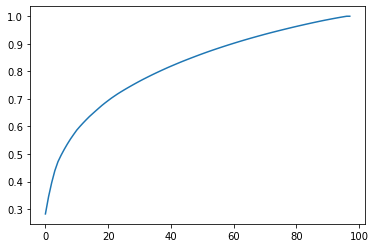

In [21]:
# Plot cumulative variance
x_values = np.arange(len(pca.explained_variance_ratio_))
cum_var = pca.explained_variance_ratio_.cumsum()

ax = sns.lineplot(x=x_values, y=cum_var)


### Plot the eigenvectors

(1, 1, 96, 96, 32)


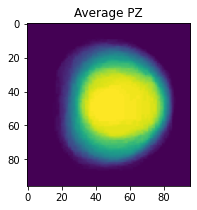

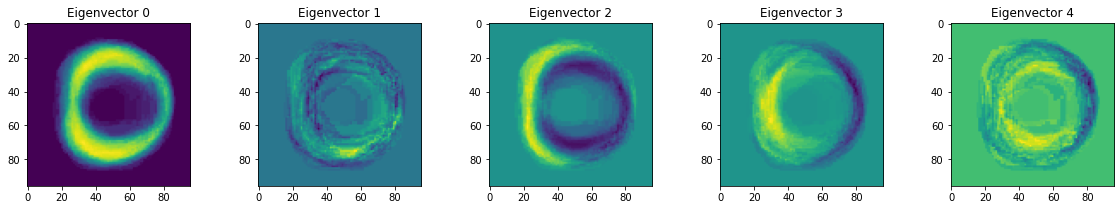

In [22]:
n_vectors = 5

mean_cg = batch_unflatten(np.expand_dims(pca.mean_, axis=0), size=PX_cg.shape[1:])
print(mean_cg.shape)

eigenvectors = batch_unflatten(pca.components_, size=PX_cg.shape[1:])
slice_num = eigenvectors.shape[-1]//2

plt.figure('PZ PCA', (20, 3))
plt.title('Average PZ')
plt.imshow(mean_cg[0,0,:,:,slice_num])
plt.show()


plt.figure('PZ Eigenvectors', (20, 3))
for i in range(n_vectors):    
    plt.subplot(1, 5, i+1)
    plt.title('Eigenvector {}'.format(i))
    plt.imshow(eigenvectors[i,0,:,:,slice_num])
plt.show()

### Reconstruct the original data from the learned PCA space

In [23]:
pca = pca_image(PX_cg, n_components=16)
Y_pred = pca_image_transform(PX_cg, pca)
# Performa classification
thr = 0.5
Y_pred[Y_pred<thr] = 0
Y_pred[Y_pred>=thr] = 1

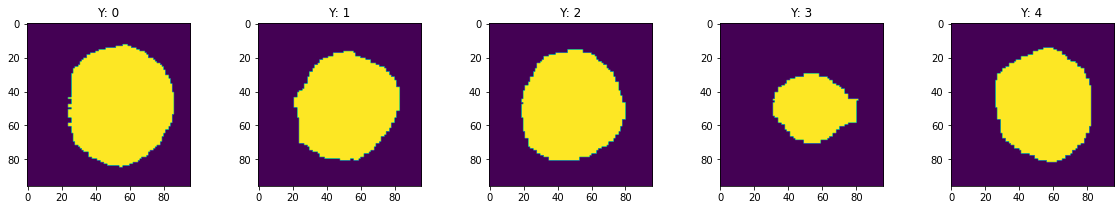

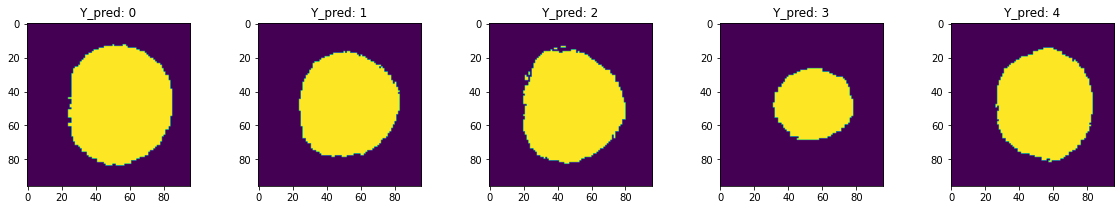

In [24]:
plot_recons(PX_cg, Y_pred)

In [25]:
df = evalute(PX_cg, Y_pred)
df.describe()

,DICE,HD,MAD,N
count,98.000000,98.000000,98.000000,98.0
mean,0.934581,2.286844,0.545204,16.0
std,0.026506,0.621718,0.148041,0.0
min,0.841856,1.000000,0.120623,16.0
25%,0.920152,2.000000,0.435911,16.0
50%,0.940127,2.000000,0.536506,16.0
75%,0.952718,2.449490,0.620640,16.0
max,0.993899,5.000000,1.060564,16.0


### Evaluate on the test dataset (Prostate3T)

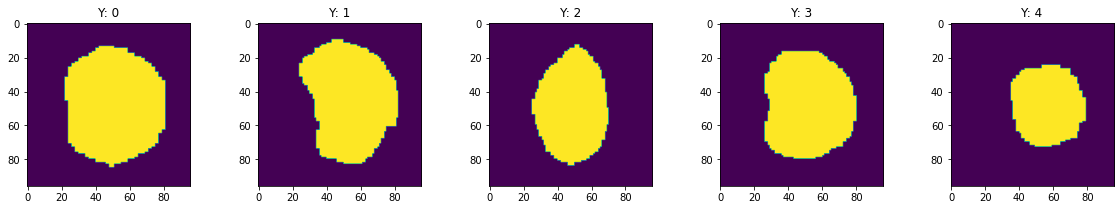

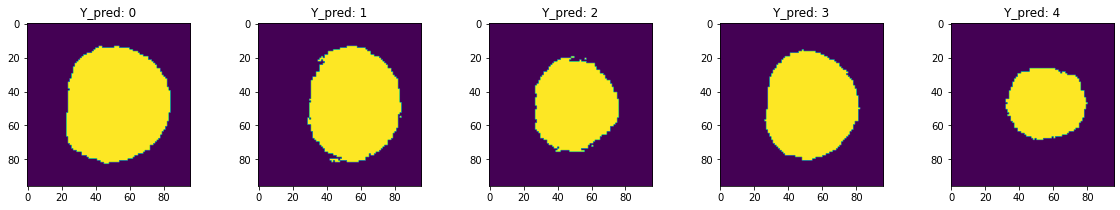

,DICE,HD,MAD,N
count,30.000000,30.000000,30.000000,30.0
mean,0.850396,4.883879,1.175992,16.0
std,0.061635,2.046289,0.374912,0.0
min,0.688971,2.449490,0.537220,16.0
25%,0.838663,3.200864,0.935627,16.0
50%,0.877906,4.300770,1.116951,16.0
75%,0.890042,5.677728,1.329293,16.0
max,0.909595,10.049876,2.239765,16.0


In [26]:
pca = pca_image(PX_cg, n_components=16)
Y_test = pca_image_transform(P3_cg, pca)
# Performa classification
thr = 0.5
Y_test[Y_test<thr] = 0
Y_test[Y_test>=thr] = 1

plot_recons(P3_cg, Y_test)
df = evalute(P3_cg, Y_test)
df.describe()

## Augment PCA data with symmetry
Perform left-right flipping of the data for augmentation.

In [27]:
PX_cg_sym = np.concatenate(
    [PX_cg, np.flip(PX_cg, axis=2)], 
    axis=0)
print(PX_cg_sym.shape)

(196, 1, 96, 96, 32)


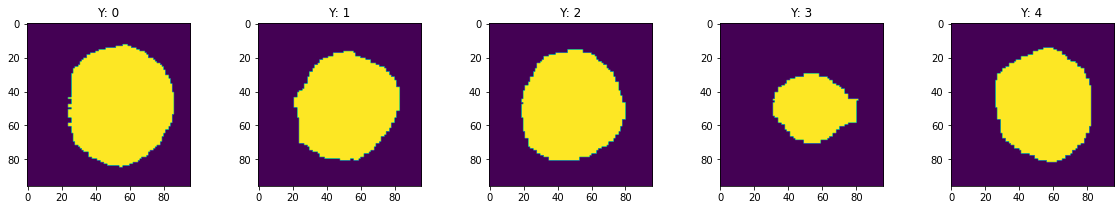

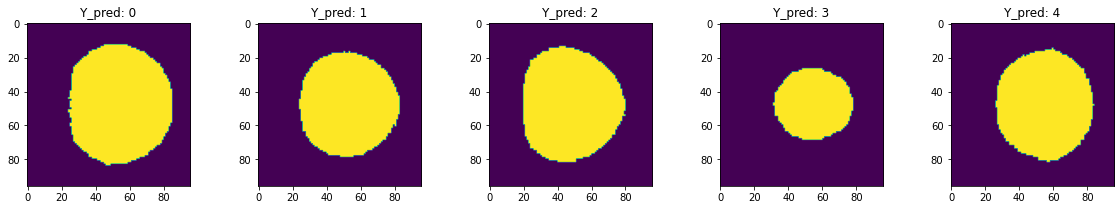

,DICE,HD,MAD,N
count,98.000000,98.000000,98.000000,98.0
mean,0.923696,2.549012,0.631135,16.0
std,0.025362,0.650905,0.150316,0.0
min,0.822000,1.414214,0.383202,16.0
25%,0.910348,2.236068,0.527782,16.0
50%,0.928942,2.236068,0.610145,16.0
75%,0.941417,2.957107,0.696229,16.0
max,0.961794,4.582576,1.246605,16.0


In [28]:
pca = pca_image(PX_cg_sym, n_components=16)
Y_pred = pca_image_transform(PX_cg, pca)
# Performa classification
thr = 0.5
Y_pred[Y_pred<thr] = 0
Y_pred[Y_pred>=thr] = 1

plot_recons(PX_cg, Y_pred)
df = evalute(PX_cg, Y_pred)
df.describe()

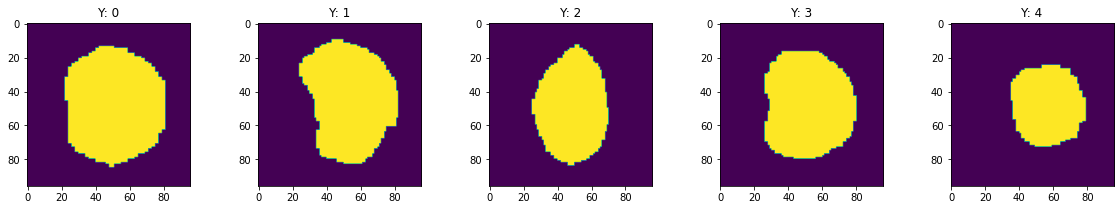

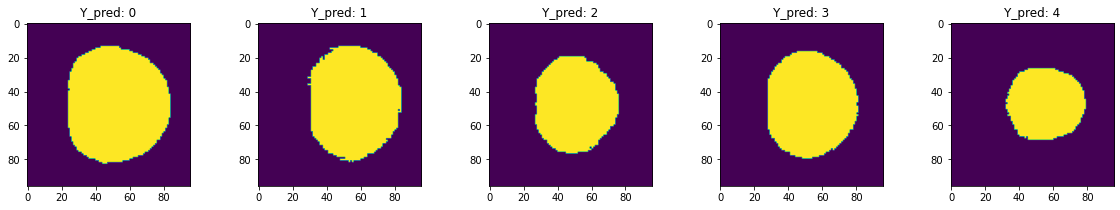

,DICE,HD,MAD,N
count,30.000000,30.000000,30.000000,30.0
mean,0.854511,4.731448,1.122930,16.0
std,0.060444,1.851392,0.352839,0.0
min,0.696778,2.236068,0.568167,16.0
25%,0.844619,3.273096,0.874687,16.0
50%,0.881943,4.182873,1.051824,16.0
75%,0.892511,5.654713,1.349144,16.0
max,0.914758,10.049876,2.223817,16.0


In [29]:
pca = pca_image(PX_cg_sym, n_components=16)
Y_test = pca_image_transform(P3_cg, pca)
# Performa classification
thr = 0.5
Y_test[Y_test<thr] = 0
Y_test[Y_test>=thr] = 1

plot_recons(P3_cg, Y_test)
df = evalute(P3_cg, Y_test)
df.describe()

### Save the PCA model out

In [30]:
n = 16

pca = pca_image(PX_cg_sym, n_components=n)

In [31]:
M = batch_unflatten(np.expand_dims(pca.mean_, axis=0), size=PX_cg_sym.shape[1:])
V = batch_unflatten(pca.components_, size=PX_cg_sym.shape[1:])

# Append the mean and eigenvectors
P = np.concatenate((M,V), axis=0)
print(P.shape)

# Get the eigenvalues
C = np.sqrt(pca.singular_values_)
U = np.insert(C, 0, 1)
print(U.shape)

(17, 1, 96, 96, 32)
(17,)


In [32]:
OUTPUT_PATH = os.path.join(EXP_PATH,'CG_segm_eigenvalues_16.npz')
np.savez(OUTPUT_PATH, U)
OUTPUT_PATH = os.path.join(EXP_PATH,'CG_segm_eigenvectors_16.npz')
np.savez(OUTPUT_PATH, P)